In [3]:
# %load_ext autoreload
# %autoreload 2

# import sys
# sys.path.append('..')

In [245]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

from lib.obs import hourly_precip
from lib.enso import oni_trimonthly

## Load SFO rainfall

In [5]:
sfo_precip = hourly_precip('SFO', '1960-07-01', '2021-06-30', filter_measurable=False)

In [6]:
sfo_monthly = sfo_precip[['valid', 'precip_in']].resample('M', on='valid').sum().reset_index()
sfo_monthly['valid'] = sfo_monthly['valid'].to_numpy().astype('datetime64[M]')

In [7]:
sfo_monthly.head()

,valid,precip_in
0,1960-07-01,0.00
1,1960-08-01,0.00
2,1960-09-01,0.00
3,1960-10-01,0.28
4,1960-11-01,4.15


## Load ONI trimonthly

In [8]:
oni = oni_trimonthly()

In [9]:
oni['day'] = 1
oni['year'] = oni.YR
oni['date'] = pd.to_datetime(oni[['year', 'MONTH', 'day']])
oni = oni[['date', 'ANOM']]

oni.head()

,date,ANOM
0,1950-01-01,-1.53
1,1950-02-01,-1.34
2,1950-03-01,-1.16
3,1950-04-01,-1.18
4,1950-05-01,-1.07


## Load NCEP Reanalysis R1

In [409]:
ds_mon = xr.open_dataset('hgt.mon.mean.nc')
ds_mon_mean = xr.open_dataset('hgt.mon.ltm.nc')

/Users/jitang/anaconda/envs/weather-env-2/lib/python3.8/site-packages/xarray/coding/times.py:463: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/jitang/anaconda/envs/weather-env-2/lib/python3.8/site-packages/xarray/coding/times.py:83: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:0.0. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:0.0). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/Users/jitang/anaconda/envs/weather-env-2/lib/python3.8/site-packages/xarray/core/indexing.py:568: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continu

In [410]:
def coerce_ltm_ds(ds, years):
    orig_times = ds.time.values
    concat_datasets = []
    for year in years:
        ds_for_year = ds.copy()
        newtimes = np.array([pd.Timestamp(year=year,
                                          month=t.month,
                                          day=t.day,
                                          hour=t.hour,
                                          minute=t.minute) for t in orig_times])
        ds_for_year['time'] = newtimes
        concat_datasets.append(ds_for_year)
        
    return xr.concat(concat_datasets, dim='time')

In [411]:
ds_mon_mean = coerce_ltm_ds(ds_mon_mean, range(1970, 2021))

/Users/jitang/anaconda/envs/weather-env-2/lib/python3.8/site-packages/xarray/coding/times.py:83: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:0.0. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:0.0). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


In [412]:
def subset(p, years, months, bbox):
    def func(ds):
        kw = {}
        kw['level'] = p
        
        north, west, south, east = bbox
        kw['lon'] = slice(west, east)
        kw['lat'] = slice(north, south)
        
        time_query = np.in1d(ds['time.month'], months) & (np.in1d(ds['time.year'], years))
        kw['time'] = time_query
        
        return ds.sel(**kw)
    
    return func

In [491]:
# aleutians_bbox = (55, 170, 40, 200) # bad
aleutians_bbox = (65, 180, 45, 205)
hudson_bay_bbox = (65, 260, 50, 290)

years = range(1960, 2021)
djf = [12, 1, 2]
p = 500

In [492]:
aleutians = subset(p, years, djf, aleutians_bbox)
hudson_bay = subset(p, years, djf, hudson_bay_bbox)

h5_hgts_aleutians = aleutians(ds_mon)
h5_norms_aleutians = aleutians(ds_mon_mean)

h5_hgts_hudson = hudson_bay(ds_mon)
h5_norms_hudson = hudson_bay(ds_mon_mean)

In [493]:
h5_anoms_aleutians = h5_hgts_aleutians - h5_norms_aleutians
h5_anoms_hudson = h5_hgts_hudson - h5_norms_hudson

# h5_anoms_aleutians = h5_anoms_aleutians.sel(time=slice('1970-07-01', '2021-03-01'))
# h5_anoms_hudson = h5_anoms_hudson.sel(time=slice('1970-07-01', '2021-03-01'))

In [494]:
aleutians_anom_means = h5_anoms_aleutians.hgt.mean(['lat', 'lon'])
hudson_anom_means = h5_anoms_hudson.hgt.mean(['lat', 'lon'])

In [495]:
aleutians_anom_means.to_dataframe()['hgt'].corr(hudson_anom_means.to_dataframe()['hgt'])

-0.4702722723662949

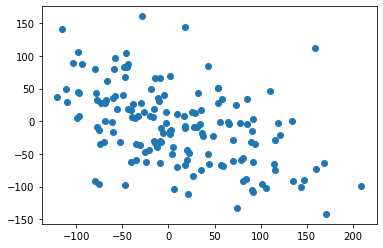

In [496]:
# plt.figure(figsize=(16, 16))

plt.scatter(aleutians_anom_means.values, hudson_anom_means.values)

In [497]:
aleutians_anom_df = aleutians_anom_means.to_dataframe().reset_index()[['time', 'hgt']]
hudson_anom_df = hudson_anom_means.to_dataframe().reset_index()[['time', 'hgt']]

## Merge together SFO rainfall, Aleutian heights, Hudson Bay heights, and ONI

In [498]:
full_df = sfo_monthly.merge(aleutians_anom_df, left_on='valid', right_on='time', how='right')
full_df = full_df.merge(hudson_anom_df, left_on='valid', right_on='time', 
                        how='inner', suffixes=['_al', '_hb'])
full_df = full_df[['valid','precip_in', 'hgt_al', 'hgt_hb']]
full_df = full_df.merge(oni, left_on='valid', right_on='date', how='left').rename(columns={'ANOM': 'oni'})

In [499]:
full_df.head()

,valid,precip_in,hgt_al,hgt_hb,date,oni
0,1970-01-01,3.12,28.230677,-8.961399,1970-01-01,0.51
1,1970-02-01,0.70,-79.776405,-91.131516,1970-02-01,0.34
2,1970-12-01,1.90,66.068237,-4.364929,1970-12-01,-1.15
3,1971-01-01,0.33,120.898987,-21.300631,1971-01-01,-1.36
4,1971-02-01,0.12,-40.298065,16.716175,1971-02-01,-1.38


In [500]:
full_df_nonino = full_df[full_df.oni < 1.5]

In [501]:
mean = full_df.precip_in.mean()
median = full_df.precip_in.median()
sd = full_df.precip_in.std()

median, sd, mean

(2.87, 2.8395259772546466, 3.535867320261438)

In [502]:
full_df.hgt_al.std(), full_df.hgt_hb.std()

(70.93585, 59.08104)

## PLOTS

In [503]:
sorted_df = full_df.sort_values(by='precip_in', ascending=False)

low_buck = sorted_df.tail(40)
high_buck = sorted_df.head(40)

rest = (~sorted_df.index.isin(low_buck.index)) & (~sorted_df.index.isin(high_buck.index))
med_buck = sorted_df[rest]

len(low_buck), len(high_buck), len(med_buck)

(40, 40, 73)

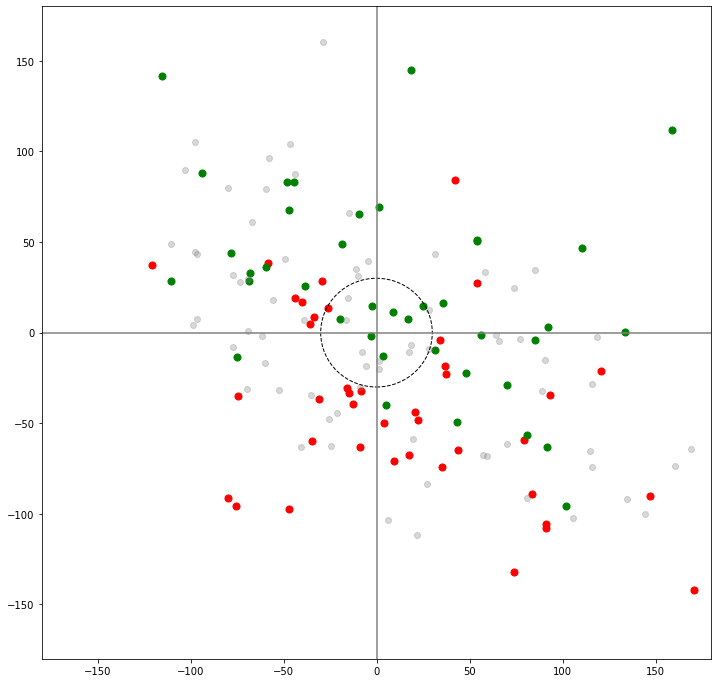

In [504]:
plt.figure(figsize=(12, 12))
plt.scatter(low_buck.hgt_al, low_buck.hgt_hb, color='red', s=50)
plt.scatter(high_buck.hgt_al, high_buck.hgt_hb, color='green', s=50)
plt.scatter(med_buck.hgt_al, med_buck.hgt_hb, color='gray', alpha=0.3)
# plt.grid(True, which='both')

plt.xlim([-180, 180])
plt.ylim([-180, 180])

circ = plt.Circle((0, 0), 30, color='k', fill=False, ls='--')
# circ2 = plt.Circle((0, 0), 50, color='k', fill=False, ls='--')
plt.gca().add_patch(circ)
# plt.gca().add_patch(circ2)

plt.axhline(y=0, color='gray')
plt.axvline(x=0, color='gray')

In [505]:
threshold = 30
df_to_use = full_df

circle_of_death = (df_to_use.hgt_al ** 2 + df_to_use.hgt_hb ** 2) < threshold ** 2

q1 = df_to_use[(df_to_use.hgt_al < 0) & (df_to_use.hgt_hb < 0) & ~circle_of_death]
q2 = df_to_use[(df_to_use.hgt_al < 0) & (df_to_use.hgt_hb > 0) & ~circle_of_death]
q3 = df_to_use[(df_to_use.hgt_al > 0) & (df_to_use.hgt_hb > 0) & ~circle_of_death]
q4 = df_to_use[(df_to_use.hgt_al > 0) & (df_to_use.hgt_hb < 0) & ~circle_of_death]

len(q1), len(q2), len(q3), len(q4)

(23, 45, 16, 52)

{'whiskers': [<matplotlib.lines.Line2D at 0x1724506d0>,
 'caps': [<matplotlib.lines.Line2D at 0x172450d90>,
 'boxes': [<matplotlib.lines.Line2D at 0x172450370>,
 'medians': [<matplotlib.lines.Line2D at 0x17245d490>,
 'fliers': [<matplotlib.lines.Line2D at 0x17245d7f0>,
 'means': []}

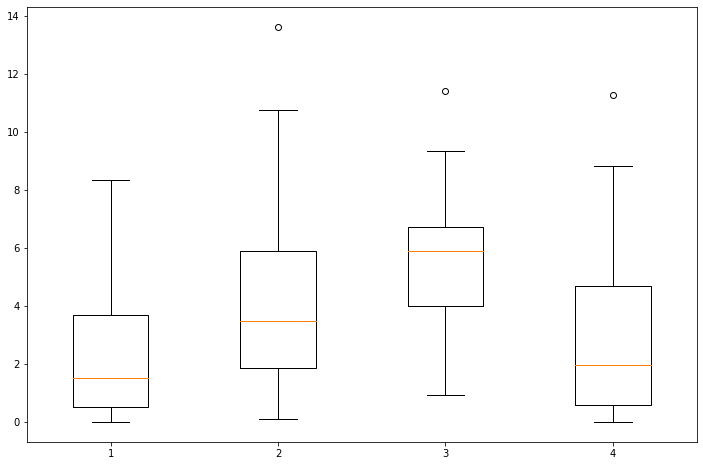

In [506]:
plt.figure(figsize=(12, 8))
plt.boxplot([q1.precip_in, q2.precip_in, q3.precip_in, q4.precip_in])
# plt.ylim([-0.5, 10])

{'bodies': [<matplotlib.collections.PolyCollection at 0x1724e3fa0>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x1724e3e20>,
 'cmins': <matplotlib.collections.LineCollection at 0x1724e3d60>,
 'cbars': <matplotlib.collections.LineCollection at 0x1724c53d0>}

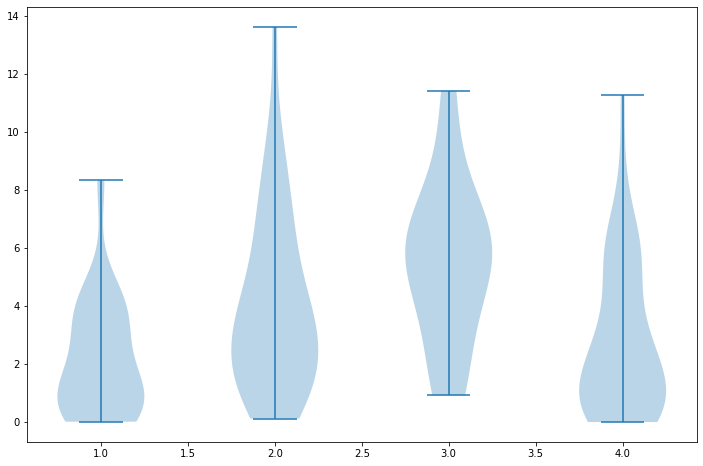

In [507]:
plt.figure(figsize=(12, 8))
plt.violinplot([q1.precip_in, q2.precip_in, q3.precip_in, q4.precip_in])

## Find Hudson Bay corr — control for weak Aleutian hgt signal

In [508]:
minimal_al = full_df[(full_df.hgt_al > -30) & (full_df.hgt_al < 30)]
len(minimal_al)

47

In [509]:
pearsonr(minimal_al.hgt_hb,minimal_al.precip_in)

(0.4484226398506586, 0.001571456494638099)

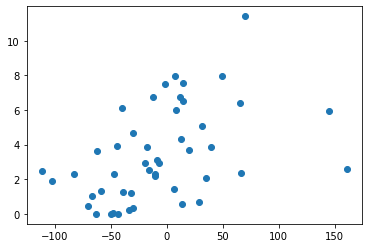

In [510]:
plt.scatter(x=minimal_al.hgt_hb, y=minimal_al.precip_in)

## Find Aleutian Low corr — control for weak Hudson Bay signal

In [511]:
minimal_hb = full_df[(full_df.hgt_hb > -30) & (full_df.hgt_hb < 30)]
len(minimal_hb)

58

In [512]:
pearsonr(minimal_hb.hgt_al,minimal_hb.precip_in)

(0.08098203713583342, 0.545638225293915)

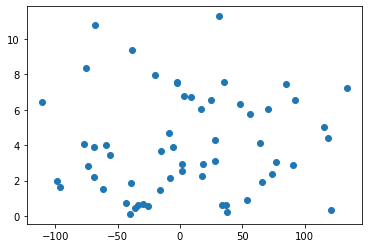

In [513]:
plt.scatter(x=minimal_hb.hgt_al, y=minimal_hb.precip_in)

## Find ONI corr — control for weak Hudson Bay Low

In [514]:
weak_hb = full_df[full_df.hgt_hb > 0]
len(weak_hb)

69

In [515]:
pearsonr(weak_hb.oni, weak_hb.precip_in)

(0.21177042734804818, 0.08066644307715135)

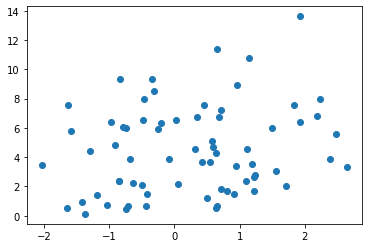

In [516]:
plt.scatter(weak_hb.oni, weak_hb.precip_in)

## Find Aleutian low corr — control for non-strong Nino

In [517]:
non_nino = full_df[full_df.oni < 1.5]
len(non_nino)

137

In [518]:
pearsonr(non_nino.hgt_al, non_nino.precip_in)

(0.026770879938072867, 0.7561581617785361)

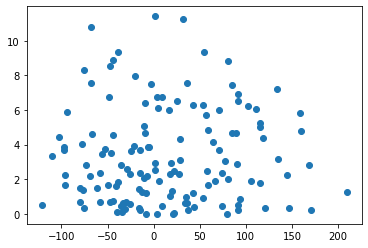

In [519]:
plt.scatter(non_nino.hgt_al, non_nino.precip_in)

## Find correlations between ONI and Hudson Bay/Aleutian heights

In [520]:
pearsonr(full_df.oni, full_df.hgt_hb)

(0.25469379622940036, 0.0014874769265338093)

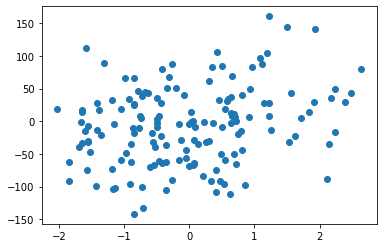

In [521]:
plt.scatter(full_df.oni, full_df.hgt_hb)

In [522]:
full_df[(full_df.hgt_hb < -30) & (full_df.oni > 1)]

,valid,precip_in,hgt_al,hgt_hb,date,oni
8,1972-12-01,0.72,83.777237,-88.918648,1972-12-01,2.12
65,1991-12-01,2.70,-69.881912,-31.133457,1991-12-01,1.53
139,2016-02-01,0.88,-74.276833,-35.240620,2016-02-01,2.14


In [523]:
pearsonr(full_df.oni, full_df.hgt_al)

(-0.28879436144732795, 0.00029420936896026585)

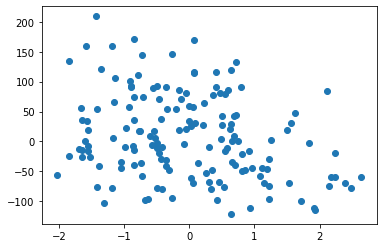

In [524]:
plt.scatter(full_df.oni, full_df.hgt_al)